In [1]:
from probe_experiment import *
from handcrafted_datasets import Dataset
from models import *
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
dataset = Dataset('ladders', 'C:\\Users\\andre\\go-ai\\data', 0.8, 0.2, 1024)
dataset.shuffle('train')
train_loader =  dataset.loader('train', max_ram_files=25)
test_loader = dataset.loader('test', max_ram_files=25)

done loading data
split sizes:
train 552
test 138


In [3]:
import numpy as np
Xls, yls = [], []
for X, y in train_loader:
    ladder_idxs = []
    y = y.numpy()
    X = X.numpy()
    for i, y_ in enumerate(y):
        if np.any(y_):
            ladder_idxs.append(i)
    Xls.append(X[ladder_idxs])
    yls.append(y[ladder_idxs])
X_train = np.concatenate(Xls, axis=0)
y_train = np.concatenate(yls, axis=0)

In [4]:
import numpy as np
Xls, yls = [], []
for X, y in test_loader:
    ladder_idxs = []
    y = y.numpy()
    X = X.numpy()
    for i, y_ in enumerate(y):
        if np.any(y_):
            ladder_idxs.append(i)
    Xls.append(X[ladder_idxs])
    yls.append(y[ladder_idxs])
X_test = np.concatenate(Xls, axis=0)
y_test = np.concatenate(yls, axis=0)

In [5]:
len(X_train)

92711

In [6]:
from torch.utils.data import DataLoader

def get_train_loader():
    return DataLoader(list(zip(X_train, y_train)), batch_size=512, shuffle=True)

def get_test_loader():
    return DataLoader(list(zip(X_test, y_test)), batch_size=512, shuffle=False)

In [7]:
def ladder_pos_only_loss(pred, target):
    bceloss = torch.nn.BCEWithLogitsLoss(reduction='none')(pred, target[:,1:2])
    bceloss = bceloss * target[:, 0]
    return bceloss.mean()

criterion = ladder_pos_only_loss #torch.nn.BCEWithLogitsLoss()

In [8]:
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
feat_models = [CutModel(go_model, i).cuda() for i in range(8)]
n_channels = [8, 64, 64, 64, 48, 48, 32, 32]
probe_models = [nn.Sequential(nn.Conv2d(nc, 1, 19, padding=9)).cuda() for nc in n_channels]

In [9]:
aucs = []
for depth in range(0, 8):
    print('probing at depth %d' % depth)
    feat_model = feat_models[depth]
    probe_model = probe_models[depth]
    exp = ProbeExperiment(get_train_loader, get_test_loader, feat_model)
    config = {'name':'ladders/ladder_break_d%d'%depth, 'write_log':True, 'progress_bar':False, 'save_ckpt':False}
    optimizer = torch.optim.Adam(probe_model.parameters())
    exp.run(probe_model, criterion, optimizer, 20, config)
    preds, labels = exp.get_predictions(probe_model, get_test_loader())
    
    ladder_idx = np.where(labels[:,0].flatten())
    preds = preds.flatten()[ladder_idx]
    labels = labels[:,1].flatten()[ladder_idx]
    auc = roc_auc_score(labels, preds)
    aucs.append(auc)
    print(auc)

probing at depth 0
[LOG] epoch 0 loss 0.000469, new best
[LOG] epoch 1 loss 0.000480
[LOG] epoch 2 loss 0.000467, new best
[LOG] epoch 3 loss 0.000446, new best
[LOG] epoch 4 loss 0.000426, new best
[LOG] epoch 5 loss 0.000405, new best
[LOG] epoch 6 loss 0.000387, new best
[LOG] epoch 7 loss 0.000367, new best
[LOG] epoch 8 loss 0.000348, new best
[LOG] epoch 9 loss 0.000334, new best
[LOG] epoch 10 loss 0.000318, new best
[LOG] epoch 11 loss 0.000305, new best
[LOG] epoch 12 loss 0.000294, new best
[LOG] epoch 13 loss 0.000281, new best
[LOG] epoch 14 loss 0.000274, new best
[LOG] epoch 15 loss 0.000264, new best
[LOG] epoch 16 loss 0.000257, new best
[LOG] epoch 17 loss 0.000249, new best
[LOG] epoch 18 loss 0.000247, new best
[LOG] epoch 19 loss 0.000241, new best
0.48077478588334255
probing at depth 1
[LOG] epoch 0 loss 0.000522, new best
[LOG] epoch 1 loss 0.000358, new best
[LOG] epoch 2 loss 0.000304, new best
[LOG] epoch 3 loss 0.000272, new best
[LOG] epoch 4 loss 0.000251, n

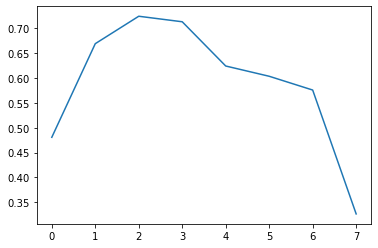

In [11]:
import matplotlib.pyplot as plt
plt.plot(aucs)